# data prepro

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms.functional import rotate, InterpolationMode, to_tensor
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,  download=True)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_idx = np.random.choice(len(mnist_train), size=5000, replace=False)
test_idx  = np.random.choice(len(mnist_test),  size=5000, replace=False)

class RotatedDataset(Dataset):
    def __init__(self, base_ds, indices, angle_range=(-90, 90)):
        self.base     = base_ds
        self.indices  = indices
        self.angles   = np.random.uniform(angle_range[0], angle_range[1], size=len(indices)).astype(np.float32)
        self.angle_range = angle_range
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        img, _    = self.base[self.indices[i]]
        angle     = float(self.angles[i])
        img_rot   = rotate(img, angle,
                           interpolation=InterpolationMode.BILINEAR,
                           fill=0)
        x         = to_tensor(img_rot)
        return x, torch.tensor(angle)

train_ds = RotatedDataset(mnist_train, train_idx, angle_range=(-90, 90))
test_ds  = RotatedDataset(mnist_test,  test_idx,  angle_range=(-90, 90))

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_ds)} | Test samples: {len(test_ds)}")

Train samples: 5000 | Test samples: 5000


# 64 channels

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim
from pathlib import Path

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')


class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Flatten()
        )
    def forward(self, x):
        return self.net(x)

base_model = EnhancedCNNRegressor().to(device)
base_weights_path = Path('best_model.pt')
base_model.load_state_dict(torch.load(base_weights_path, map_location=device), strict=False)
for param in base_model.net.parameters():
    param.requires_grad = False  

class TransferRegressor(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Sequential(
            nn.Linear(64*7*7, 1024), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1)
        )
    def forward(self, x):
        feats = self.features(x)
        return self.head(feats).squeeze(1)

model = TransferRegressor(base_model.net).to(device)
criterion = nn.L1Loss()  # MAE
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Training loop
best_mae = float('inf')
for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_mae = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(test_loader.dataset)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), 'best_transfer.pt')
        print(f"✔ Epoch {epoch}: New best MAE={best_mae:.4f}")
    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

✔ Epoch 1: New best MAE=41.0100
Epoch  1 | Train MAE: 38.0120 | Val MAE: 41.0100
✔ Epoch 2: New best MAE=30.8591
Epoch  2 | Train MAE: 29.3171 | Val MAE: 30.8591
✔ Epoch 3: New best MAE=21.8555
Epoch  3 | Train MAE: 24.8106 | Val MAE: 21.8555
✔ Epoch 4: New best MAE=20.5492
Epoch  4 | Train MAE: 22.2578 | Val MAE: 20.5492
Epoch  5 | Train MAE: 20.1264 | Val MAE: 20.9312
✔ Epoch 6: New best MAE=18.2479
Epoch  6 | Train MAE: 18.8884 | Val MAE: 18.2479
✔ Epoch 7: New best MAE=17.2825
Epoch  7 | Train MAE: 17.4044 | Val MAE: 17.2825
✔ Epoch 8: New best MAE=16.4671
Epoch  8 | Train MAE: 16.0267 | Val MAE: 16.4671
✔ Epoch 9: New best MAE=15.7401
Epoch  9 | Train MAE: 15.2868 | Val MAE: 15.7401
Epoch 10 | Train MAE: 14.6823 | Val MAE: 16.3371
✔ Epoch 11: New best MAE=15.2183
Epoch 11 | Train MAE: 13.9711 | Val MAE: 15.2183
Epoch 12 | Train MAE: 13.4306 | Val MAE: 16.3956
✔ Epoch 13: New best MAE=14.3241
Epoch 13 | Train MAE: 13.3566 | Val MAE: 14.3241
Epoch 14 | Train MAE: 12.9429 | Val MAE: 

# 32 channels 2 layers

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim
from pathlib import Path

# Device setup
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')


class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten()
        )
    def forward(self, x):
        return self.net(x)

base_model = EnhancedCNNRegressor().to(device)
base_weights_path = Path('best_model_try.pt')
base_model.load_state_dict(torch.load(base_weights_path, map_location=device), strict=False)
for param in base_model.net.parameters():
    param.requires_grad = False  

class TransferRegressor(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Sequential(
            nn.Linear(32*7*7, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        feats = self.features(x)
        return self.head(feats).squeeze(1)

model = TransferRegressor(base_model.net).to(device)
criterion = nn.L1Loss()  
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Training loop
best_mae = float('inf')
for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_mae = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(test_loader.dataset)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), 'best_transfer.pt')
        print(f"✔ Epoch {epoch}: New best MAE={best_mae:.4f}")
    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

✔ Epoch 1: New best MAE=20.1305
Epoch  1 | Train MAE: 26.5368 | Val MAE: 20.1305
✔ Epoch 2: New best MAE=17.5150
Epoch  2 | Train MAE: 18.1309 | Val MAE: 17.5150
Epoch  3 | Train MAE: 16.6632 | Val MAE: 19.8293
✔ Epoch 4: New best MAE=17.2327
Epoch  4 | Train MAE: 16.1315 | Val MAE: 17.2327
✔ Epoch 5: New best MAE=15.8181
Epoch  5 | Train MAE: 15.7474 | Val MAE: 15.8181
✔ Epoch 6: New best MAE=14.2495
Epoch  6 | Train MAE: 14.7284 | Val MAE: 14.2495
Epoch  7 | Train MAE: 14.8824 | Val MAE: 14.4937
✔ Epoch 8: New best MAE=14.1101
Epoch  8 | Train MAE: 14.4841 | Val MAE: 14.1101
Epoch  9 | Train MAE: 13.5582 | Val MAE: 15.9589
✔ Epoch 10: New best MAE=13.7466
Epoch 10 | Train MAE: 13.5134 | Val MAE: 13.7466
✔ Epoch 11: New best MAE=13.5277
Epoch 11 | Train MAE: 13.8639 | Val MAE: 13.5277
✔ Epoch 12: New best MAE=13.0875
Epoch 12 | Train MAE: 13.4125 | Val MAE: 13.0875
Epoch 13 | Train MAE: 13.1560 | Val MAE: 13.5225
✔ Epoch 14: New best MAE=13.0810
Epoch 14 | Train MAE: 12.7667 | Val MAE

# 1 layer

In [55]:
import torch, math
import torch.nn as nn, torch.optim as optim
from pathlib import Path

# Device setup
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')


class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten()
        )
    def forward(self, x):
        return self.net(x)

base_model = EnhancedCNNRegressor().to(device)
base_weights_path = Path('best_model_try.pt')
base_model.load_state_dict(torch.load(base_weights_path, map_location=device), strict=False)
for param in base_model.net.parameters():
    param.requires_grad = False  

class TransferRegressor(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Sequential(
            nn.Linear(32*7*7, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 1)
        )
    def forward(self, x):
        feats = self.features(x)
        return self.head(feats).squeeze(1)

model = TransferRegressor(base_model.net).to(device)
criterion = nn.L1Loss()  # MAE
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Training loop
best_mae = float('inf')
for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_mae = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(test_loader.dataset)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), 'best_transfer.pt')
        print(f"✔ Epoch {epoch}: New best MAE={best_mae:.4f}")
    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

✔ Epoch 1: New best MAE=20.0325
Epoch  1 | Train MAE: 24.1341 | Val MAE: 20.0325
✔ Epoch 2: New best MAE=17.6043
Epoch  2 | Train MAE: 17.6789 | Val MAE: 17.6043
✔ Epoch 3: New best MAE=17.4609
Epoch  3 | Train MAE: 16.1928 | Val MAE: 17.4609
✔ Epoch 4: New best MAE=16.2901
Epoch  4 | Train MAE: 15.4719 | Val MAE: 16.2901
✔ Epoch 5: New best MAE=16.1798
Epoch  5 | Train MAE: 15.2707 | Val MAE: 16.1798
Epoch  6 | Train MAE: 15.0326 | Val MAE: 17.1460
Epoch  7 | Train MAE: 14.9422 | Val MAE: 16.3689
Epoch  8 | Train MAE: 14.4648 | Val MAE: 18.0410
✔ Epoch 9: New best MAE=15.9596
Epoch  9 | Train MAE: 14.4098 | Val MAE: 15.9596
✔ Epoch 10: New best MAE=15.6373
Epoch 10 | Train MAE: 13.9468 | Val MAE: 15.6373
Epoch 11 | Train MAE: 14.0196 | Val MAE: 16.4372
Epoch 12 | Train MAE: 13.9620 | Val MAE: 17.1001
Epoch 13 | Train MAE: 14.0205 | Val MAE: 16.3028
Epoch 14 | Train MAE: 13.8314 | Val MAE: 17.0934
Epoch 15 | Train MAE: 13.7359 | Val MAE: 16.0338
Epoch 16 | Train MAE: 13.7994 | Val MAE:

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim
from pathlib import Path

# Device setup
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')


class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten()
        )
    def forward(self, x):
        return self.net(x)

base_model = EnhancedCNNRegressor().to(device)
base_weights_path = Path('best_model_try.pt')
base_model.load_state_dict(torch.load(base_weights_path, map_location=device), strict=False)
for param in base_model.net.parameters():
    param.requires_grad = False  

class TransferRegressor(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Sequential(
            nn.Linear(32*7*7, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 1)
        )
    def forward(self, x):
        feats = self.features(x)
        return self.head(feats).squeeze(1)

model = TransferRegressor(base_model.net).to(device)
criterion = nn.L1Loss()  
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, dampening=0, nesterov=False, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Training loop
best_mae = float('inf')
for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_mae = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(test_loader.dataset)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), 'best_transfer.pt')
        print(f"✔ Epoch {epoch}: New best MAE={best_mae:.4f}")
    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

✔ Epoch 1: New best MAE=37.3411
Epoch  1 | Train MAE: 41.8233 | Val MAE: 37.3411
✔ Epoch 2: New best MAE=26.0694
Epoch  2 | Train MAE: 32.4885 | Val MAE: 26.0694
✔ Epoch 3: New best MAE=23.3101
Epoch  3 | Train MAE: 24.2854 | Val MAE: 23.3101
✔ Epoch 4: New best MAE=22.3695
Epoch  4 | Train MAE: 22.1917 | Val MAE: 22.3695
✔ Epoch 5: New best MAE=21.6737
Epoch  5 | Train MAE: 21.3710 | Val MAE: 21.6737
✔ Epoch 6: New best MAE=21.1280
Epoch  6 | Train MAE: 20.7257 | Val MAE: 21.1280
✔ Epoch 7: New best MAE=20.7162
Epoch  7 | Train MAE: 20.1857 | Val MAE: 20.7162
✔ Epoch 8: New best MAE=20.0711
Epoch  8 | Train MAE: 19.4778 | Val MAE: 20.0711
✔ Epoch 9: New best MAE=19.5245
Epoch  9 | Train MAE: 18.9204 | Val MAE: 19.5245
✔ Epoch 10: New best MAE=18.8969
Epoch 10 | Train MAE: 18.1675 | Val MAE: 18.8969
✔ Epoch 11: New best MAE=18.4358
Epoch 11 | Train MAE: 17.8557 | Val MAE: 18.4358
✔ Epoch 12: New best MAE=17.8470
Epoch 12 | Train MAE: 17.1683 | Val MAE: 17.8470
✔ Epoch 13: New best MAE=

# show

Overall Test MAE: 13.3384°


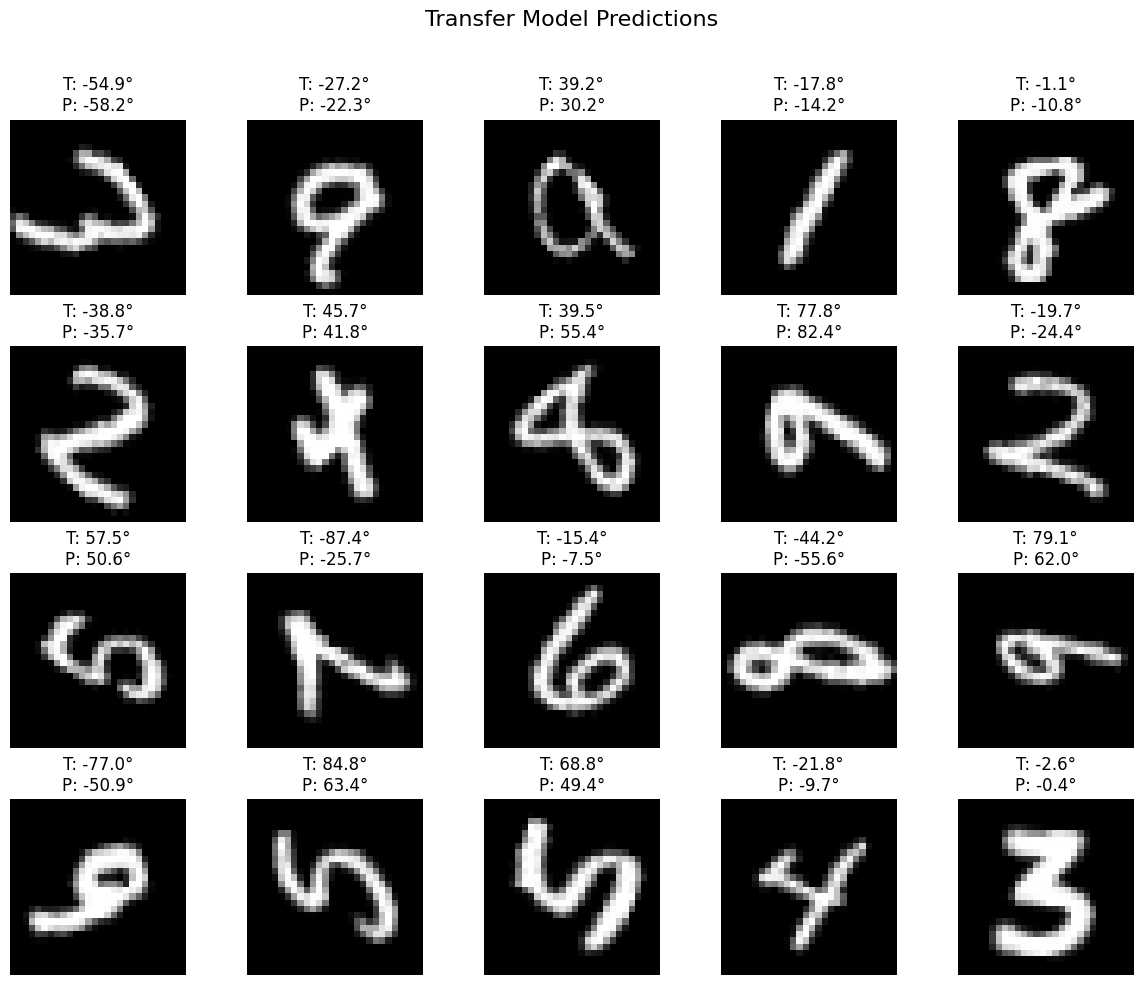

In [ ]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

model = TransferRegressor(base_model.net).to(device)
model.load_state_dict(torch.load('best_transfer.pt', map_location=device))
model.eval()

all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(yb.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

overall_mae = mean_absolute_error(all_trues, all_preds)
print(f"Overall Test MAE: {overall_mae:.4f}°")

idxs = np.random.choice(len(test_ds), 20, replace=False)
fig, axes = plt.subplots(4, 5, figsize=(12,10))
for ax, i in zip(axes.flatten(), idxs):
    x, y_true = test_ds[i]
    y_pred = model(x.unsqueeze(0).to(device)).item()
    ax.imshow(x.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title(f"T: {y_true:.1f}°\nP: {y_pred:.1f}°")
    ax.axis('off')

plt.suptitle("Transfer Model Predictions", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()